### Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from bb_rhythm import utils
import matplotlib

matplotlib.rcParams.update({'font.size': 5,
                            'ytick.major.size': 1,
                            'ytick.major.width': 0.4,
                            'xtick.major.size': 1,
                            'xtick.major.width': 0.4,
                            'font.sans-serif': 'Arial'})

In [34]:
def convert_phase_to_hours(phase, period=24):
    return - period * phase / (2 * np.pi) * (24 / period) + 12


def plot_grid(grid, var, sim=False, save_to=None, alpha_grid=None,
              thresh=None, ax=None):
    
    # Convert phase from rad to time of day.
    if var == 'phase':
        period = 400 if sim else 24
        grid = convert_phase_to_hours(grid, period)
        
    label_dict = {'phase': 'Hour of peak activity',
                  'depth': 'Avg. vertex depth'}
    
    cmap = 'viridis_r' if var == 'phase' else 'viridis'
    tick_dist = 10 if var == 'depth' else 100
    
    if type(alpha_grid) == np.ndarray:
        alpha_grid[np.isnan(alpha_grid)] = 0
        alpha_grid /= np.max(alpha_grid)
        alpha_grid[alpha_grid >= thresh] = 1
        alpha_grid[alpha_grid < thresh] = 0.1
    
    plt.figure(figsize=(3.5, 1.7), dpi=300)
    sns.heatmap(grid, xticklabels=tick_dist, yticklabels=tick_dist, square=True, ax=None,
                cmap=cmap, cbar=True, cbar_kws={'label':label_dict[var], 'shrink':0.7},
                robust=True, linewidths=0, rasterized=True, alpha=alpha_grid)
    plt.xlabel('x position [mm]')
    plt.ylabel('y position [mm]')
    
    if sim:
        plt.gca().invert_yaxis()
        plt.scatter([6,177], [6,102], c=['black', 'white'], marker='x', s=12)
    
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')

### Phase per location

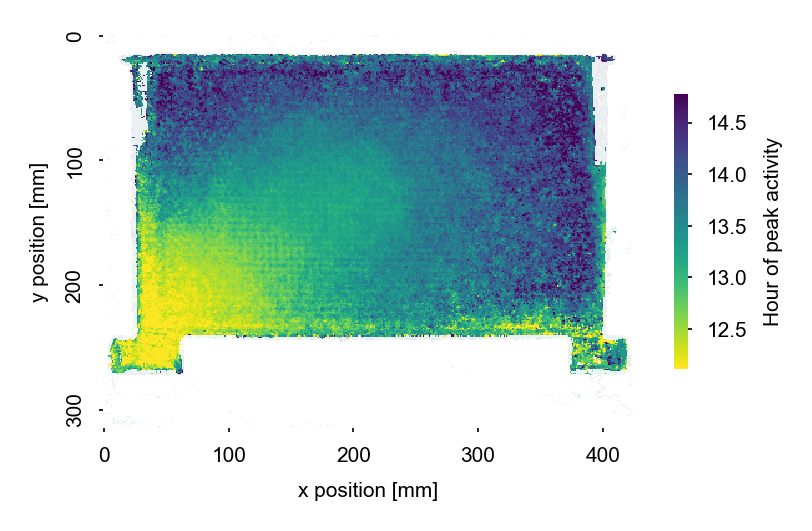

In [25]:
phase_grid = np.load(os.path.join(os.pardir, 'aggregated_results', 'phase_per_loc_2019.npy'))
phase_grid_count = np.load(os.path.join(os.pardir, 'aggregated_results', 'phase_count_per_loc_2019.npy'))

plot_grid(phase_grid, 'phase', sim=False, alpha_grid=phase_grid_count,
          thresh=0.01, save_to=os.path.join('imgs', 'phase_per_loc_2019.svg'))

### Simulated phase per location

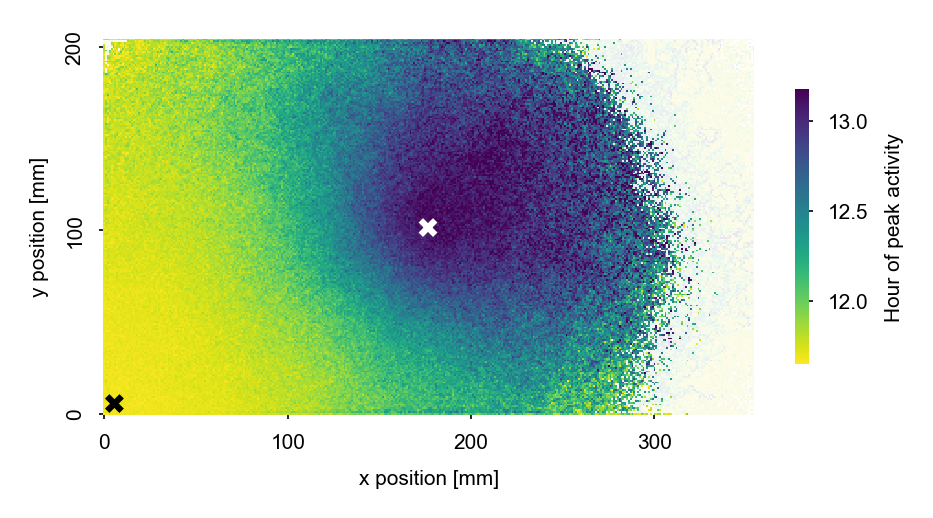

In [35]:
phase_grid = np.load(os.path.join(os.pardir, 'aggregated_results', 'phase_per_loc_simulated.npy'))
phase_grid_count = np.load(os.path.join(os.pardir, 'aggregated_results', 'phase_count_per_loc_simulated.npy'))

plot_grid(phase_grid, 'phase', sim=True, alpha_grid=phase_grid_count,
          thresh=0.01, save_to=os.path.join('imgs', 'phase_per_loc_sim.svg'))

### Node depth per location

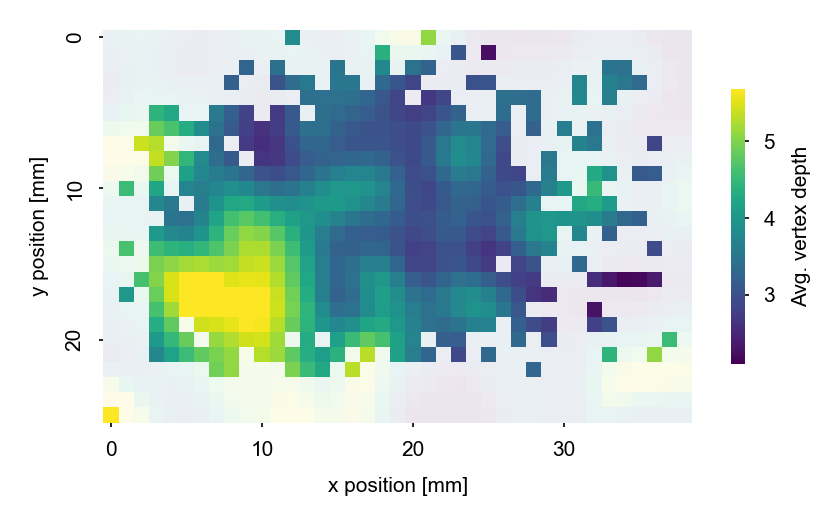

In [31]:
path = '/Users/weronik22/Documents/circadians/data_subsets/networks/overlap_network_tree_path_long.pkl'
path_df = pd.read_pickle(path)

def get_vertex_depth_per_loc(path_df):
    path_df[['x_pos', 'y_pos']] = (path_df.loc[:,['x_pos', 'y_pos']] / 10).round().astype(int)
    
    vertex_depth_grid = pd.pivot_table(path_df, index='y_pos', aggfunc='median',
                                       columns='x_pos', values='depth').to_numpy()
    vertex_depth_grid_count = pd.pivot_table(path_df, index='y_pos', aggfunc='count',
                                       columns='x_pos', values='depth').to_numpy()
    
    vertex_depth_grid = utils.nan_tolerant_gaussian_filtering(vertex_depth_grid, 1.5)
    
    return vertex_depth_grid, vertex_depth_grid_count

vertex_depth_grid, vertex_depth_grid_count = get_vertex_depth_per_loc(path_df)

plot_grid(vertex_depth_grid, 'depth', sim=False, alpha_grid=vertex_depth_grid_count,
              thresh=0.01, save_to=os.path.join('imgs', 'vertex_depth_per_loc.svg'))

### Speed change per loaction and time

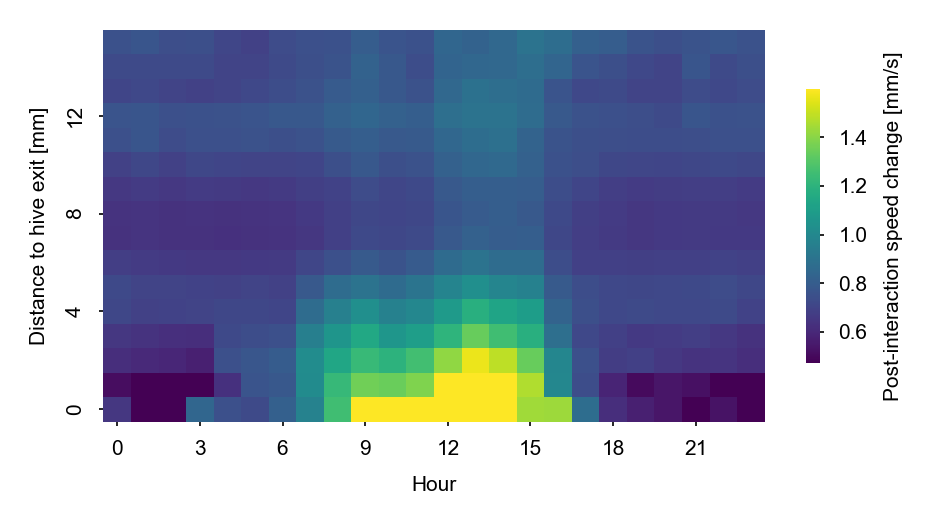

In [29]:
def heatmap_vel_ch_vs_dist(save_to=None):
    
    pivot = np.load(os.path.join(os.pardir, 'aggregated_results', 'vel_change_over_time_and_space.npy'))
    
    # Plot.
    plt.figure(figsize=(3.15, 1.7), dpi=300)
    sns.heatmap(pivot, xticklabels=3, yticklabels=4,
                cbar_kws={'label': 'Post-interaction speed change [mm/s]', 'shrink':0.7},
                robust=True, square=False, cmap='viridis', linewidths=0, rasterized=True)
    plt.gca().invert_yaxis()
    plt.ylabel('Distance to hive exit [mm]')
    plt.xlabel('Hour')
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()
    
heatmap_vel_ch_vs_dist(os.path.join('imgs', 'vel_change_vs_dist.svg'))